# 12 权重衰退

### 增加罚项

$$ loss = L(w,b) + \frac{\lambda}{2}||w||^2 $$

其中 $l(w,b)$ 是损失函数，$||w||^2$ 是权重的 L2 范数。

#### 梯度下降更新

$$ w_{t+1} = \frac{\partial loss}{\partial w_t} = (1 - \eta\lambda) w_t - \eta \frac{\partial L}{\partial w_t} $$

### 代码实现 —— 线性回归

1. 加载数据

In [4]:
import torch
from torch.utils import data
from d2l import torch as d2l

# 创造数据，注意每个地方都要用float
def tynthetic_data(w,b,num_examples):
    X = torch.normal(0,1,size=(num_examples,len(w)))
    y = torch.matmul(X,w) + b + torch.normal(0,0.01,size=(num_examples,1))
    return X,y

def load_data(batch_size,X,y,is_train=True):
    dataset = data.TensorDataset(X,y)
    data_loader = data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return data_loader

true_w = torch.tensor([[2.0], [-3.4]])
true_b = torch.tensor([1.0])
num_examples = 1000
num_test = 100
batch_size = 16
train_X,train_y = tynthetic_data(true_w, true_b, num_examples)
test_X,test_y = tynthetic_data(true_w, true_b, num_test)
train_iter = load_data(batch_size,train_X,train_y)
test_iter = load_data(batch_size,test_X,test_y,is_train=False)


2. 定义模型、损失函数和优化器

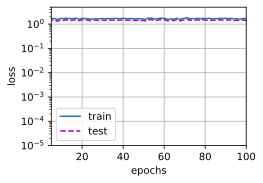

In [5]:
from torch import nn
num_inputs = 2
num_outputs = 1
lr = 0.01

def l2_penalty(w):
    res = torch.sum(w.pow(2)) / 2
    return res

w = nn.Parameter(torch.randn(num_inputs, num_outputs))
b = nn.Parameter(torch.zeros(num_outputs))
params = [w, b]

def net(X):
    return torch.matmul(X,w) + b

loss = nn.MSELoss()
optimizer = torch.optim.SGD(params, lr=lr)

num_epochs = 100

def train(lamda):
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], ylim=[1e-5,5], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y) + l2_penalty(w) * lamda
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))

train(1)

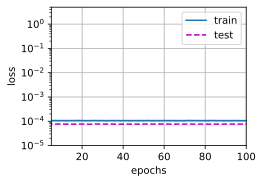

In [6]:
train(0)
# 这里效果不及预期，应当看附带资料的文件